In [1]:
%pylab inline 
from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme
from fuel.datasets import IndexableDataset

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in xrange(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX 660


[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.629049 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


In [40]:
def dist_centers(X, centers):
    return sqrt(sum((centers - X)*(centers - X), 1))

def kmeans(data, k, tolerance = 0, display=False, centers=None, last_error=sys.maxint, idx = 1000):
    if centers == None:
        d = concatenate(data)
        centers = d[choice(arange(len(d)), k)]
    #print centers[:, newaxis]
    errors = sqrt(sum((centers[:, newaxis] - data[0])**2, -1).T)
    vec_num = errors.shape[0]
    for epoch in data[1:]:
        #print epoch
        vec_num += epoch.shape[0]
        print 'Done: ', vec_num
        #print sqrt(sum((centers[:, newaxis] - epoch)**2, -1).T)
        errors = append(errors, sqrt(sum((centers[:, newaxis] - epoch)**2, -1).T),0)

    partition = argmin(errors,1)

    sets = [concatenate(data)[partition==i] for i in arange(len(centers))]
    #print partition
    new_centers = [mean(set, 0) for set in sets if len(set) >0]
    
    error = sum(amin(errors,1))/len(data)
    
    print 'Error: ', error

    if idx < 0:
        return
    if abs(last_error - error) <= tolerance:
        return centers, partition
    else:
        if(display):
            scatter(data[:,0], data[:,1], c=array(['r', 'g', 'b', 'y', 'k', 'c', 'w'])[partition])
            scatter(centers[:,0], centers[:,1], 100, ['r', 'g', 'b', 'y', 'k', 'c', 'w'])
            show()
        return kmeans(data, k, tolerance, display, array(new_centers), error, idx -1)

def dist_mixture(num, k, loc, scale, p = 10, bins = None ):
    if bins == None:
        bins = k
    samples_per_dist =  zip(arange(k), histogram(uniform(0, k, num), bins = bins)[0])
    #print samples_per_dist
    x = [array([normal(u, s, n) for (u, s) in zip(loc+p*move, scale)]).T for [move, n] in samples_per_dist]
    print array(x).shape
    return concatenate(x)

def dist_data(num, d, k, cov, bins = None):
    means = [ones(d)*3*i for i in arange(k)+1]
    if bins == None:
        bins = k
    samples_per_dist = zip(arange(k), histogram(uniform(0, k, num), bins = bins)[0])
    print 'spd', samples_per_dist
    data = array([multivariate_normal(means[k], cov[k], samples) for [k, samples] in samples_per_dist])
    return concatenate(data)
    
    
def print_hist(x, b= 10, label = "default"):
    hist, bins = np.histogram(x, bins=b)
    center = (bins[:-1] + bins[1:]) / 2
    w = 1.*(amax(x) - amin(x))/b
    
    plt.bar(center, hist, align='center', width=w)
    plt.title(label)
    plt.show()
    
def createStream(data, batch=500):
    dataset = IndexableDataset(indexables=array(data), axis_labels=set(['features', 'targets']))
    return DataStream.default_stream(dataset, iteration_scheme=SequentialScheme(dataset.num_examples, batch))
    
# TESTS
print dist_centers(array([2,2]), array([[2,2]])), [0]
print dist_centers(array([2,2]), array([[2,2], [2,3]])), [0, 1]
print dist_centers(array([2,2]), array([[4,2], [4,3]])), [2, sqrt(5)]
print dist_centers(array([2,2]), array([[4,2], [4,3], [0, 0]])), [2, sqrt(5), 2*sqrt(2)]

[ 0.] [0]
[ 0.  1.] [0, 1]
[ 2.          2.23606798] [2, 2.2360679774997898]
[ 2.          2.23606798  2.82842712] [2, 2.2360679774997898, 2.8284271247461903]


In [38]:
X, Y = array([[1,2],[2,3]]), array([[4,3]])
print append(X, Y, 0)
o = ones((10,2))
print split(o,cumsum(ones(o.shape[0]/3)*3))

data = [[5, 4], [1,2],[2,3],[4,3]]
Z = array([[1,2],[2,3],[4,3]])
print (Z[:, newaxis] - data)
print (Z[:, newaxis] - data)**2
print sum((Z[:, newaxis] - data)**2, -1).T
print 'min:', amin(Z, 1)
Y = arange(10)
argmin(X,1)
mean(X,1)
i = choice(arange(len(Y)), 2)

print i, Y[i]
print [1, 2] == [1, 2, 3]
print array([1,2]) + nan
histogram(arange(100), bins = [0,3, 50, 54, 100])

[[1 2]
 [2 3]
 [4 3]]
[array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]]), array([[ 1.,  1.]])]
[[[-4 -2]
  [ 0  0]
  [-1 -1]
  [-3 -1]]

 [[-3 -1]
  [ 1  1]
  [ 0  0]
  [-2  0]]

 [[-1 -1]
  [ 3  1]
  [ 2  0]
  [ 0  0]]]
[[[16  4]
  [ 0  0]
  [ 1  1]
  [ 9  1]]

 [[ 9  1]
  [ 1  1]
  [ 0  0]
  [ 4  0]]

 [[ 1  1]
  [ 9  1]
  [ 4  0]
  [ 0  0]]]
[[20 10  2]
 [ 0  2 10]
 [ 2  0  4]
 [10  4  0]]
min: [1 2 3]
[1 1] [1 1]
False
[ nan  nan]


(array([ 3, 47,  4, 46]), array([  0,   3,  50,  54, 100]))

150 150


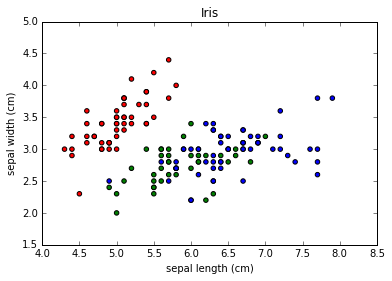

In [4]:
from sklearn import datasets 
iris = datasets.load_iris() 
print len(iris.data[:,0]), len(iris.target)
p = scatter(iris.data[:,0], iris.data[:,1], c=array(['r', 'g', 'b', 'y', 's'])[iris.target])
xlabel('sepal length (cm)')
ylabel('sepal width (cm)')
title('Iris')

Error:  93.8805036866
Error:  79.6633237588
Error:  75.2987136537
Error:  73.7522399907
Error:  71.7017835141
Error:  70.1946403481
Error:  67.3687608387
Error:  66.0258493267
Error:  65.6971436557
Error:  65.4467441938
Error:  65.3802674943
Error:  64.9433782786
Error:  64.612222563
Error:  64.289863699
Error:  64.090687882
Error:  63.8261069635
Error:  63.7272916325
Error:  63.5268455523
Error:  63.3568592805
Error:  63.1044138769
Error:  63.0139485373
Error:  62.9157935676
Error:  62.7917359686
Error:  62.7917359686


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


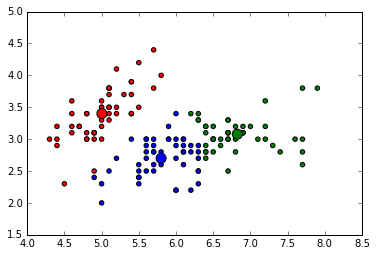

In [44]:
iris_data = iris.data[:, :2]
c, p = kmeans([iris_data], 3, 0, False)
showPlot(iris_data, c, p)

A
spd [(0, 1032), (1, 966), (2, 981), (3, 1021), (4, 1000)]
Error:  9192.08275758
Error:  7422.12014203
Error:  6696.01806336
Error:  6284.24130758
Error:  6210.42064494
Error:  6199.92856486
Error:  6199.39409885
Error:  6199.36690541
Error:  6199.39074134
Error:  6199.39074134


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


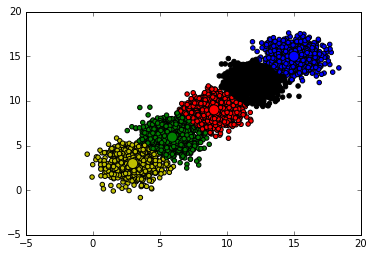

B
spd [(0, 993), (1, 1023), (2, 1011), (3, 992), (4, 981)]
Error:  10303.2607605
Error:  8290.71764249
Error:  8204.5058481
Error:  8129.66307977
Error:  8043.50586399
Error:  7967.4465692
Error:  7907.97078733
Error:  7847.52100783
Error:  7779.06525183
Error:  7680.28683378
Error:  7519.68277923
Error:  7303.57447331
Error:  7062.966268
Error:  6860.09674416
Error:  6724.23780166
Error:  6659.46153461
Error:  6640.21229696
Error:  6635.02716265
Error:  6633.47200548
Error:  6632.44442582
Error:  6631.89861433
Error:  6631.4680442
Error:  6631.19892043
Error:  6630.97515406
Error:  6630.97515406


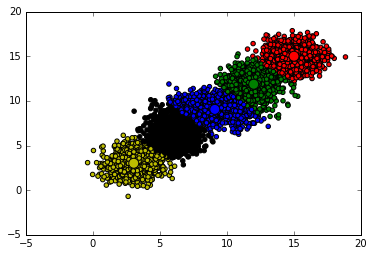

C
spd [(0, 978), (1, 985), (2, 1012), (3, 1039), (4, 986)]
Error:  12868.1618436
Error:  9848.75652594
Error:  8303.97666545
Error:  7779.46460451
Error:  7517.36780611
Error:  7282.78401373
Error:  7077.20018802
Error:  6951.31474964
Error:  6884.32075826
Error:  6859.84653365
Error:  6848.73261326
Error:  6843.96492845
Error:  6840.65715733
Error:  6838.22072009
Error:  6836.45502048
Error:  6835.48706047
Error:  6835.16776247
Error:  6835.10993007
Error:  6835.10993007


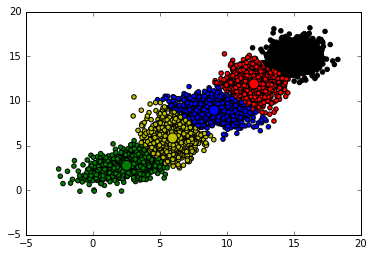

D
spd [(0, 223), (1, 115), (2, 272), (3, 84), (4, 310)]
Error:  2605.33864026
Error:  1690.72226874
Error:  1575.71748624
Error:  1527.64845779
Error:  1500.89233863
Error:  1482.2394066
Error:  1467.33120662
Error:  1457.23803733
Error:  1449.96230883
Error:  1443.3985909
Error:  1431.92877688
Error:  1427.63889001
Error:  1427.05230033
Error:  1427.01706862
Error:  1426.9710435
Error:  1427.09934063
Error:  1427.29105591
Error:  1427.51263986
Error:  1427.51263986


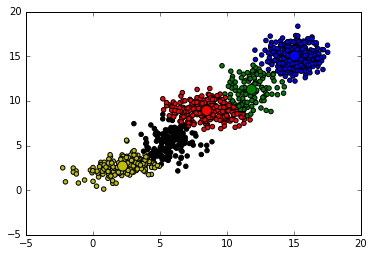

E
spd [(0, 982), (1, 988), (2, 1037), (3, 1014), (4, 979)]
Error:  16138.3371296
Error:  10203.3269078
Error:  9665.65637322
Error:  9141.45786928
Error:  8609.24812371
Error:  8335.14371783
Error:  8269.17491952
Error:  8261.45068807
Error:  8260.53640431
Error:  8260.17395476
Error:  8260.17559473


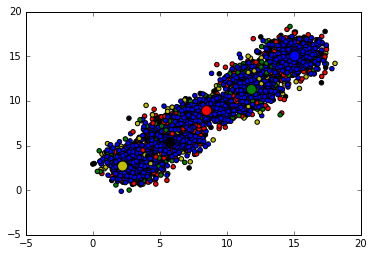

F
spd [(0, 494), (1, 478), (2, 473), (3, 522), (4, 491), (5, 496), (6, 527), (7, 495), (8, 503), (9, 521)]
Error:  97176.3273066
Error:  61024.8080057
Error:  49730.9409689
Error:  49730.9409689


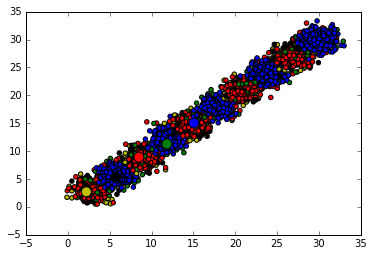

In [43]:
#1 

def showPlot(d, c, p):
    scatter(d[:,0], d[:,1], c=array(['r', 'g', 'b', 'y', 'k', 'c', 'w'])[p])
    scatter(c[:,0], c[:,1], 100, ['r', 'g', 'b', 'y', 'k', 'c', 'w'])
    show()

cov = expand_dims(identity(2),0).repeat(5, 0)
print 'A'
a = dist_data(5000, 2, 5, cov)
c, p = kmeans([a], 5, 0.01, False)
showPlot(a, c, p)

print 'B'
cov[2] = [[3,0], [0, 1]]
b = dist_data(5000, 2, 5, cov)
c, p = kmeans([b], 5, 0.01, False)
showPlot(b, c, p)

print 'C'
cov[0] = [[3,1], [1, 1]]
cd = dist_data(5000, 2, 5, cov)
c, p = kmeans([cd], 5, 0.01, False)
showPlot(cd, c, p)

print 'D'
d = dist_data(5000, 2, 5, cov, [0, 0.2, 0.3, 0.6, 0.7, 1])
c, p = kmeans([d], 5, 0.0001, False)
showPlot(d, c, p)

print 'E'
cov = expand_dims(identity(3),0).repeat(5, 0)
cov[2] = [[3,1,0],[1,1,0],[0,0,1]]
e = dist_data(5000, 3, 5, cov)
kmeans([e], 5, 0.01, False)
showPlot(e, c, p)

print 'F'
cov = expand_dims(identity(100),0).repeat(10, 0)
f = dist_data(5000, 100, 10, cov)
kmeans([f], 10, 0.01, False)
showPlot(f, c, p)

In [45]:
#2
data = dist_mixture(1000000, 1000, arange(1000), ones(1000), 100)
print data.shape

(1000,)
(1000000, 1000)


In [ ]:
#2 cd
epoch = 100000
stream = split(data, cumsum(ones(o.shape[0]/epoch)*epoch))
kmeans(stream, 1000, 0, False)

In [ ]:
for hist in dist_mixture(1000, 10, arange(10)*10, ones(10)).T:
    print_hist(hist)

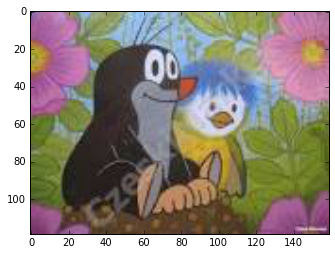

Error:  0.0715466072846
Error:  0.0580274329705
Error:  0.0542688491059
Error:  0.0523296384758
Error:  0.0514816734729


/pio/lscratch/1/os/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Error:  0.0509225778488
Error:  0.0503907574276
Error:  0.0499686554434
Error:  0.0496957076297
Error:  0.0494828464762
Error:  0.0493297721631
Error:  0.0492180057465
Error:  0.0491290412729
Error:  0.0490495458547
Error:  0.0489818133124
Error:  0.0489207087595
Error:  0.0488616780666
Error:  0.0488282434586
Error:  0.0487734231816
Error:  0.0487337042377
Error:  0.0487009678441
Error:  0.0486733030619
Error:  0.0486543798976
Error:  0.0486364614842
Error:  0.04861944607
Error:  0.0486024252996
Error:  0.0485881922826
Error:  0.0485617052383
Error:  0.0485342852464
Error:  0.0485018183603
Error:  0.0484790251635
Error:  0.0484637064769
Error:  0.0484516797398
Error:  0.0484459893149
Error:  0.0484374710229
Error:  0.0484294982879
Error:  0.0484167556493
Error:  0.0484072121845
Error:  0.0483970981364
Error:  0.0483878553924
Error:  0.0483826068551
Error:  0.0483831228751
(119, 159, 3)


In [29]:
image1 = imread('images.jpeg')
imshow(image1/256.)
show()
shape = image1.shape
image =  image1.reshape((-1,3))/256.
centers, partition = kmeans(image, 50, 0.000001, False, idx=1000)
print shape

(119, 159, 3)


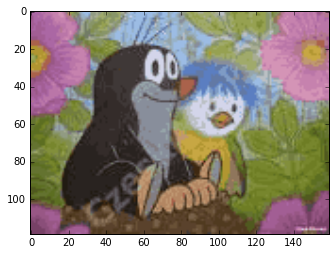

In [30]:
img = centers[partition].reshape(shape)
print img.shape
imshow(img)

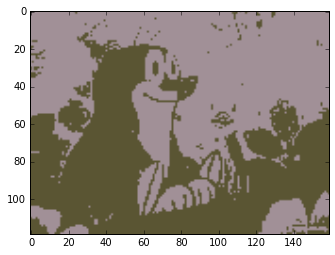

In [50]:
imshow(img.reshape(shape))